In [1]:
import os
import sys
sys.path.append(os.path.join('..', 'src'))

import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Add, Flatten, Dot, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

### Load and prepare data

In [2]:
DATA_DIR = os.path.join('..', 'data', 'processed', 'filtering')

In [3]:
with open(os.path.join(DATA_DIR, 'train_ratings.pickle'), 'rb') as file:
    train_ratings = pickle.load(file)

with open(os.path.join(DATA_DIR, 'test_ratings.pickle'), 'rb') as file:
    test_ratings = pickle.load(file)

In [4]:
# get number of users and items
M = 1 + max(
    max([i[0] for i in train_ratings.keys()]),
    max([i[0] for i in test_ratings.keys()])
)
N = 1 + max(
    max([i[1] for i in train_ratings.keys()]),
    max([i[1] for i in test_ratings.keys()])
)
M, N

(9166, 1998)

In [5]:
X_train = np.array(list(zip(*train_ratings.keys())))
y_train = np.array(list(train_ratings.values()))
               
X_test = np.array(list(zip(*test_ratings.keys())))
y_test = np.array(list(test_ratings.values()))

In [6]:
# compute global mean
mean = np.mean(y_train)
mean

4.238397468222365

### Build the model

In [7]:
def build_model(M, N, K, lmbda=0.):
    """
    Build a model for matrix factorization
    Args:
        M (int): number of users
        N (int): number of items
        K (int): size of inner (latent) dimension
        lmbda (float): L2-regularization parameter
    Returns:
        keras.models.Model: model for MF
    """
    w = Input((1, )) 
    u = Input((1, ))
    w_vec = Embedding(M, K)(w)  # user embeddings
    u_vec = Embedding(N, K)(u)  # item embeddings
    
    w_bias = Embedding(M, 1)(w)  # user bias
    u_bias = Embedding(N, 1)(u)  # item bias
    
    r_pred = Dot(axes=2)([w_vec, u_vec]) # predicted rating w/o biases
    r_pred = Add()([r_pred, w_bias, u_bias])
    r_pred = Flatten()(r_pred)
    
    model = Model(inputs=[w, u], outputs=[r_pred])
    return model

### Example of keras-model architecture

In [10]:
model = build_model(M, N, K=100)

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 100)       916600      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 100)       199800      input_4[0][0]                    
____________________________________________________________________________________________

### Train the model

In [13]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [14]:
LOSS = 'mse'
LR = 0.02
RATE_DECAY = 0
EPOCHS = 10
BATCH_SIZE = 64

In [16]:
def search_k(min_k, max_k, step_k=1, l2_reg=0):
    train_score, test_scores = [], []
    
    for k in range(min_k, max_k + 1, step_k):
        print(f"Number of latent factors: {k}", end='  ')
        model_k = build_model(M, N, k, lmbda=l2_reg)
        model_k.compile(
            loss=LOSS,
            optimizer=SGD(lr=LR, decay=RATE_DECAY, momentum=0.95),
            metrics=[rmse]
        )
        
        history = model_k.fit(
            x=[*X_train],
            y=y_train-mean,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=([*X_test], y_test - mean),
            verbose=0,
            shuffle=True
        )
        loss, train_rmse_score = model_k.evaluate([*X_train], y_train - mean, verbose=0)
        loss, rmse_score = model_k.evaluate([*X_test], y_test - mean, verbose=0)
        print(f"Train RMSE: {train_rmse_score}, test RMSE: {rmse_score}")
        train_score.append(train_rmse_score)
        test_scores.append(rmse_score) 
    return train_score, test_scores

In [17]:
train_scores, test_scores = search_k(3, 30, step_k=3)

Number of latent factors: 3  Train RMSE: 0.802067756652832, test RMSE: 0.8574426770210266
Number of latent factors: 6  Train RMSE: 0.8010419011116028, test RMSE: 0.8575156927108765
Number of latent factors: 9  Train RMSE: 0.8002146482467651, test RMSE: 0.8572883605957031
Number of latent factors: 12  Train RMSE: 0.7992062568664551, test RMSE: 0.8574571013450623
Number of latent factors: 15  Train RMSE: 0.7980633974075317, test RMSE: 0.8571497201919556
Number of latent factors: 18  Train RMSE: 0.7971892952919006, test RMSE: 0.8576011657714844
Number of latent factors: 21  Train RMSE: 0.7964701652526855, test RMSE: 0.8573501110076904
Number of latent factors: 24  Train RMSE: 0.7955167889595032, test RMSE: 0.8571281433105469
Number of latent factors: 27  Train RMSE: 0.7947237491607666, test RMSE: 0.8575751185417175
Number of latent factors: 30  Train RMSE: 0.7935563325881958, test RMSE: 0.8571064472198486


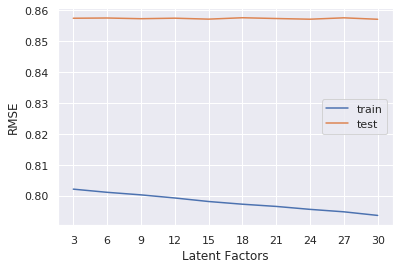

In [22]:
sns.lineplot(np.arange(3, 30 + 1, 3), train_scores)
sns.lineplot(np.arange(3, 30 + 1, 3), test_scores)
plt.xticks(np.arange(3, 31,3))
plt.legend(['train', 'test'])
plt.xlabel('Latent Factors')
plt.ylabel('RMSE');
plt.savefig("latent.png")